In [106]:
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import deque, OrderedDict
from copy import deepcopy
import numpy as np
import json
import gymnasium as gym
from gymnasium import spaces

NC = 10
NT = 7
NL = 2
TSCOPE = 720 #hours
NCUTS = 5
MAXCARGO = 250
MEANASSAY = [0.15, 0.15, 0.3, 0.25, 0.15]
UNITVOLCUTMAX = [0.25, 0.16, 0.3, 0.3, 0.25]
TKMIN = 7
TKMAX = 100

In [2]:
def randomComp(nCrudes):
    c = np.random.random(nCrudes)
    return c/np.sum(c)

In [3]:
def randomSched(nCrudes, cargoSizes, tScope):
    d = dict()
    cargoVols = np.random.permutation(cargoSizes)
    cargoCrudes = np.random.randint(0, 10, cargoVols.shape[0])
    cargoTimes = np.sort(np.random.randint(0, tScope, cargoVols.shape[0]))
    for i, t in enumerate(cargoTimes):
        comp = np.zeros(10)
        comp[cargoCrudes[i]] = 1
        d[t] = crudeParcel(cargoVols[i], comp)
    return d
    

In [101]:
def randomAssay(nCrudes=NC, nCuts=NCUTS):
    a = []
    if nCuts == NCUTS:
        for i in range(nCrudes):
            b = []
            for j in range(nCuts):
                b.append(max(0.2*MEANASSAY[j], np.random.normal(MEANASSAY[j], 0.5*MEANASSAY[j])))
            a.append(b/np.sum(b))
    else:
        for i in range(nCrudes):
            a.append(randomComp(nCuts))
    return np.transpose(np.array(a))

In [102]:
randomAssay(NC, NCUTS)


array([[0.11446057, 0.08007482, 0.20041263, 0.30415478, 0.14866873,
        0.15153118, 0.27939061, 0.08873312, 0.15110109, 0.10152261],
       [0.11951457, 0.14035113, 0.06430741, 0.1639923 , 0.15009243,
        0.05839909, 0.20777544, 0.10759335, 0.1428605 , 0.03072179],
       [0.31105634, 0.30878658, 0.57436835, 0.29715359, 0.27765058,
        0.38220202, 0.19179227, 0.39044321, 0.0966842 , 0.48819117],
       [0.31963499, 0.2132455 , 0.05456552, 0.07859977, 0.22818082,
        0.26720438, 0.18264695, 0.30984867, 0.44504986, 0.28862837],
       [0.13533353, 0.25754198, 0.1063461 , 0.15609956, 0.19540744,
        0.14066333, 0.13839473, 0.10338165, 0.16430435, 0.09093605]])

In [6]:
def flatten_dict(dd, separator='_', prefix=''):
    '''https://stackoverflow.com/questions/6027558/flatten-nested-dictionaries-compressing-keys'''
    return { prefix + separator + k if prefix else k : v
             for kk, vv in dd.items()
             for k, v in flatten_dict(vv, separator, kk).items()
             } if isinstance(dd, dict) else { prefix : dd }

In [7]:
class crudeTanksEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(crudeTanksEnv, self).__init__()

        self.action_space = spaces.Dict({
            'farmTanks': spaces.MultiDiscrete([13, 6]),
            'unitFeed': spaces.Box(low=0, high=1.0, shape=(), dtype=np.float64)
        })

        self.observation_space = spaces.Dict({
            'tkVols': spaces.Box(low=0, high=MAXCARGO, shape=(NT,), dtype=np.float64), 
            'tkVolUtils': spaces.Box(low=0, high=MAXCARGO, shape=(NT,), dtype=np.float64), 
            'tkVolEmpties': spaces.Box(low=-50, high=MAXCARGO, shape=(NT,), dtype=np.float64), 
            'tkComps': spaces.Box(low=0, high=1.0, shape=(NT, NC), dtype=np.float64), 
            'tkCuts': spaces.Box(low=0, high=1.0, shape=(NT, NCUTS), dtype=np.float64), 
            'linVols': spaces.Box(low=0, high=20.0, shape=(NL,), dtype=np.float64), 
            'linComps': spaces.Box(low=0, high=1.0, shape=(NL, NC), dtype=np.float64),
            'linCuts': spaces.Box(low=0, high=1.0, shape=(NL, NCUTS), dtype=np.float64),
            'unitProds': spaces.Box(low=0, high=10.0, shape=(NCUTS,), dtype=np.float64)

        })
        
        self.S = siteReset({})
        return
  
    def step(self, action):
    # Execute one time step within the environment
        return siteStep(action, self.S)

    def reset(self, seed=None, **kwargs):
    # Reset the state of the environment to an initial state
        super().reset(seed=seed)
        self.S, obs = siteReset(kwargs)
        return obs, {'sched': deepcopy(self.S.cargo.sched), 
                     'assay': deepcopy(self.S.unit.assay), 
                     'unitVolCutMax': deepcopy(self.S.unit.volCutMax)}
  
    def render(self, mode='human', close=False):
    # Render the environment to the screen
        siteRender(self.S)
        return

In [8]:
#del gym.envs.registry['crudeTanksEnv']
gym.envs.registration.register(
    'crudeTanksEnv-v0',
    crudeTanksEnv,
    reward_threshold=500,
    max_episode_steps=720
)

In [9]:
env = gym.envs.make('crudeTanksEnv-v0')
env.spec
#env = crudeTanksEnv()

NameError: name 'siteReset' is not defined

In [ ]:
state0, fixDict = env.reset()
state = env.step(env.action_space.sample())
env.render()

In [ ]:
#env.observation_space.sample()
env.reset(seed=200560)[0]

In [ ]:
env.observation_space.sample() in env.observation_space, env.reset()[0] in env.observation_space

In [ ]:
from gymnasium.utils.env_checker import check_env
check_env(env)

In [10]:
class crudeParcel():
    def __init__(self, vol: float, comp: np.array):
        self.vol = vol
        self.comp = comp
    
    def toDict(self):
        return {'vol': self.vol, 'comp': self.comp.tolist()}

    @classmethod
    def fromDict(cls, d):
        return cls(d['vol'], np.array(d['comp']))
    
    def __str__(self):
        return 'vol: {:6.2f} comp: {}'.format(self.vol, np.array_str(self.comp, precision=2, suppress_small=True))
    
    def __repr__(self):
        return 'vol: {:6.2f} comp: {}'.format(self.vol, np.array_str(self.comp, precision=2, suppress_small=True))

In [43]:
class crudeTank(crudeParcel):
    def __init__(self, name: str, vol: float, comp: np.array, volMin: float, volMax: float):
        super().__init__(vol, comp)
        self.name = name
        self.volMin = volMin
        self.volMax = volMax
        assert self.vol >= self.volMin, '{} Initial volumen below min'.format(self.name)  
        assert self.vol <= self.volMax, '{} Initial volumen above max'.format(self.name)
        self.actVol()
        return
    
    def actVol(self, v=0):
        self.vol += v
        self.volUtil = self.vol - self.volMin
        self.volEmpty = self.volMax - self.vol
        return
    
    def getParcel(self, v):
        assert v > 0, '{} Volume drawn must be positive'.format(self.name)
        v = min(v, self.volUtil)
        self.actVol(-v)
        return crudeParcel(v, self.comp)
    
    def putParcel(self, cP):
        self.comp = (self.vol * self.comp + cP.vol * cP.comp)/(self.vol+cP.vol)
        self.actVol(cP.vol)
        if self.vol > self.volMax:
            print('\nTank {} vol above max after putParcel\n'.format(self.name))
        return
        
    def toDict(self):
        return {'volUtil': self.volUtil, 'volMin': self.volMin,'volMax': self.volMax, 
                'cP': super().toDict()}        
    
    @classmethod
    def fromDict(cls, name, d):
        return cls(name, d['cP']['vol'], np.array(d['cP']['comp']), d['volMin'], d['volMax'])
    
    @classmethod
    def fromCrudeParcel(cls, name, cP: crudeParcel, volMin, volMax):
        return cls(name, cP.vol, cP.comp, volMin, volMax)

    def __str__(self):
        return 'Tank {:6s} {}'.format(self.name, super().__str__())    
    

In [32]:
class crudeCargo(crudeTank):
    def __init__(self, name: str, sched: dict):
#         if isinstance(list(sched.keys())[0], str):
        self.sched = sched
        if 0 in sched.keys():
            super().__init__(name, self.sched[0].vol, self.sched[0].comp, 0, MAXCARGO)
            del self.sched[0]
        else:
            super().__init__(name, 0, np.zeros(NC), 0, MAXCARGO)
    
    def act(self, t):
        if len(self.sched) > 0:
            ts = min(self.sched.keys())
            if self.vol < np.finfo(np.float32).eps and t <= ts:
                self.vol = self.sched[ts].vol
                self.comp = self.sched[ts].comp
                self.actVol()
                del self.sched[ts]
        return

    def toDict(self):
        d = super().toDict()
        d['sched'] = {}
        for k, v in self.sched.items():
            d['sched'][str(k)] = v.toDict()
        return d     

    @classmethod
    def fromDict(cls, name, d):
        sched = {int(k): crudeParcel.fromDict(v) for k, v in d['sched'].items()}
        return cls(name, sched)
        

In [52]:
class line():
    def __init__(self, name: str, lineVol: float, lineCrudeParcels: list):
        assert lineVol == sum([cP.vol for cP in lineCrudeParcels]), "line Crude Parcels don't add up to line vol"
        self.name = name
        self.lineVol = lineVol
        self.lineCrudeParcels = deque(lineCrudeParcels)
        return
    
    def move(self, cP):
        moveList = []
        if np.array_equal(cP.comp, self.lineCrudeParcels[-1].comp):
            self.lineCrudeParcels[-1].vol += cP.vol
        else:
            self.lineCrudeParcels.append(cP)
        v = cP.vol
        while v > 0:
            if self.lineCrudeParcels[0].vol > v:
                moveList.append(crudeParcel(v, self.lineCrudeParcels[0].comp))
                self.lineCrudeParcels[0].vol -= v
                v = 0
            else:
                moveList.append(self.lineCrudeParcels[0])
                v -= self.lineCrudeParcels.popleft().vol
        return moveList
                
    def toDict(self):
        return {'lineVol': self.lineVol, 'cP': [cP.toDict() for cP in self.lineCrudeParcels]}        
    
    @classmethod
    def fromDict(cls, name, d):
        return cls(name, d['lineVol'], [crudeParcel.fromDict(v) for v in d['cP']])

    def __str__(self):
        txt = ''
        for cP in self.lineCrudeParcels:
            txt += 'Line {:5s} {}\n'.format(self.name, cP.__str__())
        return txt[:-1]

In [66]:
class crudeTanks():
    def __init__(self):
        self.ts = dict()
        return
    
    def add(self, cT):
        self.ts[cT.name] = cT
        return
    
    def get(self, name):
        return self.ts[name]
    
    def toDict(self):
        d = dict()
        for k in self.ts.keys():
            d[k] = self.ts[k].toDict()
        return d
    
    @classmethod
    def fromDict(cls, d):
        ts = cls()
        for k, v in d.items():
            if 'sched' in v.keys():
                cargo = crudeCargo.fromDict(k, v)
                ts.add(cargo)
            else:
                ts.add(crudeTank.fromDict(k, v))
        return cargo, ts
    
    def __str__(self):
        txt = ''
        for k in self.ts.keys():
            txt += '{}\n'.format(self.ts[k].__str__())
        return txt[:-1]

    def __repr__(self):
        return self.__str__()

In [47]:
class lines():
    def __init__(self):
        self.ls = dict()
        return
    
    def add(self, l):
        self.ls[l.name] = l
        return
    
    def get(self, name):
        return self.ls[name]
    
    def toDict(self):
        d = dict()
        for k in self.ls.keys():
            d[k] = self.ls[k].toDict()
        return d

    @classmethod
    def fromDict(cls, d):
        ls = cls()
        for k, v in d.items():
            ls.add(line.fromDict(k, v))
        return ls

    def __str__(self):
        txt = ''
        for k in self.ls.keys():
            txt += '{}\n'.format(self.ls[k].__str__())
        return txt[:-1]
    
    def __repr__(self):
        return self.__str__()

In [17]:
class pump():
    def __init__(self, name, volMax):
        self.name = name
        self.volMax = volMax
        return
    
    def flow(self, v=None):
        if v is None:
            return self.volMax
        else:
            return min(v, self.volMax)

    def toDict(self):
        return {'volMax': self.volMax}        
    
    @classmethod
    def fromDict(cls, name, d):
        return cls(name, d['volMax'])

    def __str__(self):
        return 'Pump {:5s} {:4.2f}'.format(self.name, self.volMax)

In [54]:
class pumps():
    def __init__(self):
        self.ps = dict()
    
    def add(self, p):
        self.ps[p.name] = p
        return
    
    def get(self, name):
        return self.ps[name]
    
    def toDict(self):
        d = dict()
        for k in self.ps.keys():
            d[k] = self.ps[k].toDict()
        return d

    @classmethod
    def fromDict(cls, d):
        ps = cls()
        for k, v in d.items():
            ps.add(pump.fromDict(k, v))
        return ps

    def __str__(self):
        txt = ''
        for k in self.ps.keys():
            txt += '{}\n'.format(self.ps[k].__str__())
        return txt[:-1]
    
    def __repr__(self):
        return self.__str__()

In [60]:
class crudeUnit():
    def __init__(self, name: str, assay: np.array, volCutMax: np.array):
        self.name = name
        self.assay = np.array(assay)
        self.volCutMax = np.array(volCutMax)
        self.prod = np.zeros(self.assay.shape[0])
        return
    
    def distil(self, cP):
        yields = np.matmul(self.assay, cP.comp)
        v = np.min(np.append(self.volCutMax/yields, [cP.vol]))
        self.prod = v * yields
        return v

    def toDict(self):
        return {'name': self.name, 'assay': self.assay.tolist(), 'volCutMax': self.volCutMax.tolist(),'prod': self.prod.tolist()}
    
    @classmethod
    def fromDict(cls, d):
        return cls(d['name'], np.array(d['assay']), np.array(d['volCutMax']))

    def __str__(self):
        return 'Prod: {}'.format(np.array_str(self.prod, precision=2, suppress_small=True))
    
    def __repr__(self):
        return self.__str__()

In [67]:
class site():
    def __init__(self):
        self.tanks = crudeTanks()
        self.lines = lines()
        self.pumps = pumps()
        self.cargo = None
        self.unit = None
        self.t = 0
        self.reward = 0
        self.lastAction = np.zeros(2, dtype=int)
        self.movesLog = OrderedDict()
        self.prodsLog = OrderedDict()
        self.tkVolsLog = OrderedDict()
        return
    
    def addTank(self, cT):
        self.tanks.add(cT)
        return
    
    def addCargo(self, cT):
        self.tanks.add(cT)
        self.cargo = cT
        return

    def addLine(self, lin):
        self.lines.add(lin)
        return
    
    def addPump(self, p):
        self.pumps.add(p)
        return
    
    def addUnit(self, u):
        self.unit = u
        return

    def tank(self, name):
        return self.tanks.get(name)
    
    def line(self, name):
        return self.lines.get(name)

    def pump(self, name):
        return self.pumps.get(name)

    def move(self, tin, tout, lin, p, v=None):
        v = self.pump(p).flow(v)
        v = min(v, self.tank(tin).volUtil)
        v = min(v, self.tank(tout).volEmpty)
        if v > 0:
            moveList = self.line(lin).move(self.tank(tin).getParcel(v))
            for cP in moveList:
                self.tank(tout).putParcel(cP)
            self.movesLog[self.t][tin] = -1
            self.movesLog[self.t][tout] = 1
        return

    def move_(self, tin, tout, v):
        v = min(v, self.tank(tin).volUtil)
        v = min(v, self.tank(tout).volEmpty)
        self.tank(tout).putParcel(self.tank(tin).getParcel(v))
        return
    
    def feedUnit(self, tk, p, per=None):
        if per is not None:
            v = per*self.pump(p).flow()
        v = self.pump(p).flow(v)
        v = min(v, self.tank(tk).volUtil)
        if v > 0:
            v = self.unit.distil(crudeParcel(v, self.tank(tk).comp))
            _ = self.tank(tk).getParcel(v)
            self.reward += v
            self.movesLog[self.t][tk] = -1
            self.prodsLog[self.t] = self.unit.prod
        return

    def newStep(self):
        self.t += 1
        self.cargo.act(self.t)
        self.reward = 0.0
        self.movesLog[self.t] = {}
        return
    
    def toDict(self):
        d = dict()
        d['tanks'] = self.tanks.toDict()
        d['lines'] = self.lines.toDict()
        d['pumps'] = self.pumps.toDict()
        d['unit'] = self.unit.toDict()
        return d
    
    @classmethod
    def fromDict(cls, d):
        S = cls()
        S.cargo, S.tanks = crudeTanks.fromDict(d['tanks'])
        S.lines = lines.fromDict(d['lines'])
        S.pumps = pumps.fromDict(d['pumps'])
        S.unit = crudeUnit.fromDict(d['unit'])
        return S

    def toObs(self):
        d = OrderedDict({'linComps': [], 'linCuts': [], 'linVols': [], 'tkComps': [], 'tkCuts': [], 
                         'tkVolEmpties': [], 'tkVolUtils': [], 'tkVols': [], 'unitProds': 0})
        for k in self.tanks.ts.keys():
            d['tkVols'].append(self.tank(k).vol)
            d['tkVolUtils'].append(self.tank(k).volUtil)
            d['tkVolEmpties'].append(self.tank(k).volEmpty)
            d['tkComps'].append(self.tank(k).comp)
            d['tkCuts'].append(np.matmul(self.unit.assay, self.tank(k).comp))
        for k in self.lines.ls.keys():
            d['linVols'].append(self.line(k).lineVol)
            d['linComps'].append(self.line(k).lineCrudeParcels[0].comp)
            d['linCuts'].append(np.matmul(self.unit.assay, self.line(k).lineCrudeParcels[0].comp))
        for k in d.keys():
            d[k] = np.array(d[k])
        d['unitProds'] = self.unit.prod
        return d
            
    def __str__(self):
        txt = self.tanks.__str__() + '\n'
        txt += self.lines.__str__()
        return txt    
    
    def render(self):
        siteRender(self)
        return

In [111]:
def siteReset(kwargs):
    np.random.default_rng(200560)
    
    if 'siteDict' in kwargs.keys() and kwargs['siteDict'] is not None:
        S = site.fromDict(kwargs['siteDict'])
    else:
        S = site()
        sch = randomSched(NC, [120, 120, 60, 80, 80, 80], 720)
        S.addCargo(crudeCargo('jetty', sch))
        S.addLine(line('lcru01', 5, [crudeParcel(5, randomComp(NC))]))
        S.addPump(pump('p01', 10))
        for tn in ['101', '102', '103', '201', '202', '203']:
            S.addTank(crudeTank(tn, min(TKMAX, max(TKMIN, np.random.normal(0.5*TKMAX, 0.25*TKMAX))), 
                                randomComp(NC), TKMIN, TKMAX))
        S.addLine(line('lcru12', 7.5, [crudeParcel(3, randomComp(NC)), crudeParcel(4.5, randomComp(NC))]))
        S.addPump(pump('p12', 5))
        if 'assay' in kwargs.keys() and kwargs['assay'] is not None:
            assay = kwargs['assay']
            assert (np.abs(np.sum(assay, axis=0)-1) < 1.E-3).all(), 'crude yieds sum not 1'
        else:
            assay = randomAssay(NC, NCUTS)
        if 'unitVolCutMax' in kwargs.keys() and kwargs['unitVolCutMax'] is not None:    
            S.addUnit(crudeUnit('unit', assay, kwargs['unitVolCutMax']))
        else:
            S.addUnit(crudeUnit('unit', assay, UNITVOLCUTMAX))
        S.addPump(pump('p23', 1))
    obs = S.toObs()
    S.tkVolsLog[S.t] = obs['tkVols']
    return S, obs

In [22]:
def siteStep(action, S):

    S.newStep()

    if action['farmTanks'][0] == 0:
        tk1 = None
    elif action['farmTanks'][0] == 1:
        S.move('jetty', '101', 'lcru01', 'p01')
        tk1 = None
    elif action['farmTanks'][0] == 2:
        S.move('jetty', '102', 'lcru01', 'p01')
        tk1 = None
    elif action['farmTanks'][0] == 3:
        S.move('jetty', '103', 'lcru01', 'p01')
        tk1 = None
    elif action['farmTanks'][0] == 4:
        tk1 = '101'
    elif action['farmTanks'][0] == 5:
        tk1 = '102'
    elif action['farmTanks'][0] == 6:
        tk1 = '103'
    elif action['farmTanks'][0] == 7:
        S.move('jetty', '101', 'lcru01', 'p01')
        tk1 = '102'
    elif action['farmTanks'][0] == 8:
        S.move('jetty', '101', 'lcru01', 'p01')
        tk1 = '103'
    elif action['farmTanks'][0] == 9:
        S.move('jetty', '102', 'lcru01', 'p01')
        tk1 = '101'
    elif action['farmTanks'][0] == 10:
        S.move('jetty', '102', 'lcru01', 'p01')
        tk1 = '103'
    elif action['farmTanks'][0] == 11:
        S.move('jetty', '103', 'lcru01', 'p01')
        tk1 = '101'
    elif action['farmTanks'][0] == 12:
        S.move('jetty', '103', 'lcru01', 'p01')
        tk1 = '102'
                
    if action['farmTanks'][1] == 0:
        if tk1 is not None:
            S.move(tk1, '201', 'lcru12', 'p12')
        S.feedUnit('202', 'p23', action['unitFeed'])
    elif action['farmTanks'][1] == 1:
        if tk1 is not None:
            S.move(tk1, '201', 'lcru12', 'p12')
        S.feedUnit('203', 'p23', action['unitFeed'])
    elif action['farmTanks'][1] == 2:
        if tk1 is not None:
            S.move(tk1, '202', 'lcru12', 'p12')
        S.feedUnit('201', 'p23', action['unitFeed'])
    elif action['farmTanks'][1] == 3:
        if tk1 is not None:
            S.move(tk1, '202', 'lcru12', 'p12')
        S.feedUnit('203', 'p23', action['unitFeed'])
    elif action['farmTanks'][1] == 4:
        if tk1 is not None:
            S.move(tk1, '203', 'lcru12', 'p12')
        S.feedUnit('201', 'p23', action['unitFeed'])
    elif action['farmTanks'][1] == 5:
        if tk1 is not None:
            S.move(tk1, '203', 'lcru12', 'p12')
        S.feedUnit('202', 'p23', action['unitFeed'])
    if S.t > 1:
        if action['farmTanks'][1] != S.lastAction[1]:
            S.reward -= 0.1
        if action['farmTanks'][0] != S.lastAction[0]:
            S.reward -= 0.1
    S.lastAction = action['farmTanks']
    
    obs = S.toObs()
    S.tkVolsLog[S.t] = obs['tkVols']
    
    return obs, S.reward, S.t >= TSCOPE, False, {}

In [23]:
def siteRender(S):
    m = np.zeros((NT, TSCOPE+1), dtype=int)
    t2n = {t: i for i, t in enumerate(S.tanks.ts.keys())}
    for t, d in S.movesLog.items():
        for tk, i in d.items():
            m[t2n[tk], t] = i
    
    m1 = np.zeros((NCUTS, TSCOPE+1), dtype=float)
    f = np.zeros(TSCOPE+1, dtype=float)
    for t, a in S.prodsLog.items():
        m1[:, t] = a
        f[t] = np.sum(a)
    
    m2 = np.zeros((NT, TSCOPE+1), dtype=float)
    for t, a in S.tkVolsLog.items():
        m2[:, t] = a
    
    fig = plt.figure(figsize=(12, 16))
    gs = plt.GridSpec(nrows=3+NT, ncols=1, height_ratios=[2] + NT*[3/NT] +[2, 1])
    axs = (3+NT)*[0]
    
    i = 3+NT-1
    axs[i] = fig.add_subplot(gs[i, 0])
    axs[i].plot(range(f.shape[0]), f)
    axs[i].set_ylabel('unit feed')
    axs[i].set_xlabel('time')
    axs[i].set_xlim(0, TSCOPE)
    
    i = 0
    axs[i] = fig.add_subplot(gs[0, 0], sharex=axs[3+NT-1])
    axs[i].set_title('Crude Tanks Gym Environment')
    plt.setp(axs[i].get_xticklabels(), visible=False)
    
    # make a color map of fixed colors
    cmap = colors.ListedColormap(['green', 'white', 'red'])
    bounds=[-1, -0.5, 0.5, 1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # tell imshow about color map so that only set colors are used
    axs[i].imshow(m, interpolation='nearest', origin='upper',
                        cmap=cmap, norm=norm, aspect='auto')
    axs[i].set_yticks(range(m.shape[0]))
    axs[i].set_yticklabels(t2n.keys())
    axs[i].set_ylabel('tank')
    
    for i in range(1, NT+1):
        tkString = list(S.tanks.ts.keys())[i-1]
        axs[i] = fig.add_subplot(gs[i, 0], sharex=axs[3+NT-1])
        axs[i].plot(range(m2.shape[1]), m2[i-1])
        axs[i].set_ylabel(tkString)
        axs[i].set_xlim(0, TSCOPE)
        axs[i].set_ylim(0, S.tank(tkString).volMax)
        plt.setp(axs[i].get_xticklabels(), visible=False)
    
    i = 3+NT-2
    axs[i] = fig.add_subplot(gs[i, 0], sharex=axs[3+NT-1])

    for j in range(m1.shape[0]):
        axs[i].plot(range(m1.shape[1]), m1[j], label='c'+str(j))
    axs[i].legend(loc="upper left")
    axs[i].set_ylabel('cut flow')
    axs[i].set_xlim(0, TSCOPE)
    plt.setp(axs[i].get_xticklabels(), visible=False)

    plt.show

    return

224.79338445509958


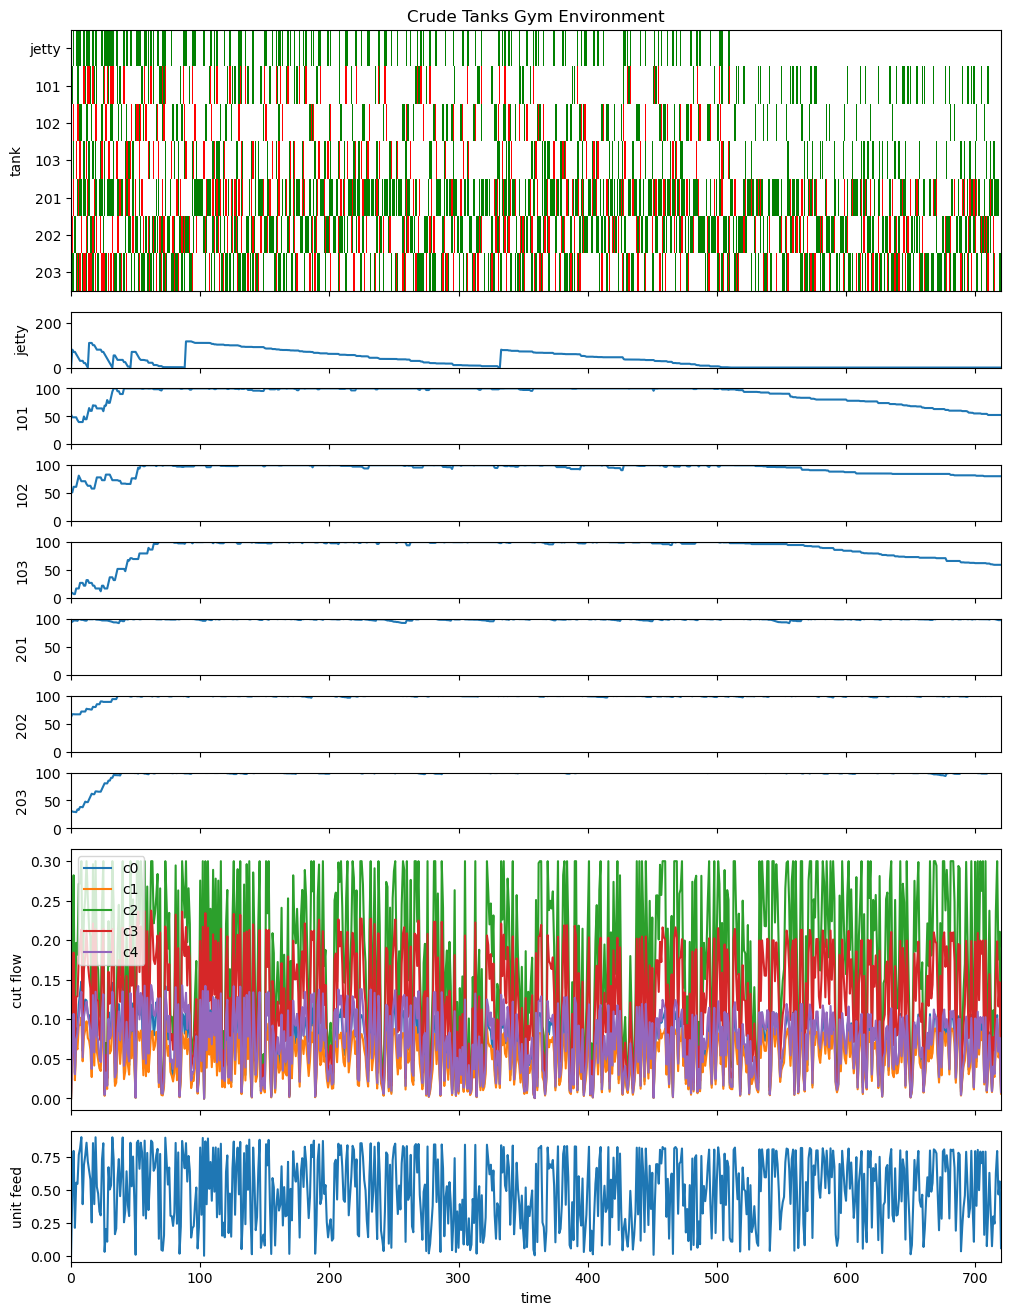

In [112]:
env = crudeTanksEnv()
assay= np.array([[0.34, 0.07378915, 0.18976778, 0.0965682 , 0.0560275 ,
         0.18278751, 0.16887304, 0.18447396, 0.10185099, 0.30329977],
        [0.01613761, 0.25604147, 0.09091845, 0.04861686, 0.07216525,
         0.17118472, 0.24657441, 0.26018187, 0.2586041 , 0.06364646],
        [0.30760134, 0.20194489, 0.23450989, 0.19652344, 0.21819169,
         0.20081736, 0.1216459 , 0.13550506, 0.55190178, 0.10268111],
        [0.13612882, 0.28888501, 0.20397846, 0.27124323, 0.36099407,
         0.37934646, 0.2028836 , 0.26887879, 0.07478973, 0.21544528],
        [0.20016654, 0.17933948, 0.28082542, 0.38704828, 0.29262148,
         0.06586395, 0.26002305, 0.15096033, 0.01285341, 0.31492738]])
unitVolCutMax =  np.array([0.1, 0.25, 0.2, 0.2, 0.25])

with open('siteDict.json', 'r') as f:
    siteDict = json.load(f) 

#state0, fixDict = env.reset(siteDict=siteDict)
#state0, fixDict = env.reset(assay=assay, unitVolCutMax=unitVolCutMax)
#state0, fixDict = env.reset()
state0, fixDict = env.reset(assay=None, unitVolCutMax=None)

totalReward = 0
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, _, _ = env.step(action)
    totalReward += reward 
print(totalReward)
env.render()

In [81]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

env.reset()
# env.S.toDict()
with open('siteDict.json', 'w') as f:
    json.dump(env.S.toDict(), f, cls=NumpyEncoder, indent=4) 

with open('siteDict.json', 'r') as f:
    siteDict = json.load(f) 

env.reset(siteDict=siteDict)
# env.reset()
env.step(env.action_space.sample())

(OrderedDict([('linComps',
               array([[0.        , 0.        , 0.        , 0.        , 0.        ,
                       0.        , 1.        , 0.        , 0.        , 0.        ],
                      [0.13444837, 0.10453353, 0.02598822, 0.06399148, 0.03330614,
                       0.14155059, 0.14527943, 0.14695979, 0.10165377, 0.10228868]])),
              ('linCuts',
               array([[0.44926933, 0.10893137, 0.09615491, 0.31086372, 0.03478067],
                      [0.20369365, 0.1724137 , 0.23961491, 0.22592933, 0.15834841]])),
              ('linVols', array([5. , 7.5])),
              ('tkComps',
               array([[0.        , 0.        , 0.        , 0.        , 0.        ,
                       0.        , 1.        , 0.        , 0.        , 0.        ],
                      [0.09885988, 0.02697407, 0.09082818, 0.19731823, 0.17321951,
                       0.03999742, 0.03576638, 0.13322994, 0.11232976, 0.09147663],
                      [0.18419867

In [65]:
env.S.toDict()

{'tanks': {'jetty': {'volUtil': 0,
   'volMin': 0,
   'volMax': 250,
   'cP': {'vol': 0,
    'comp': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
   'sched': {'34': {'vol': 80,
     'comp': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
    '162': {'vol': 60,
     'comp': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
    '364': {'vol': 120,
     'comp': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]},
    '430': {'vol': 120,
     'comp': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
    '454': {'vol': 80,
     'comp': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
    '474': {'vol': 80,
     'comp': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]}}},
  '101': {'volUtil': 53,
   'volMin': 7,
   'volMax': 100,
   'cP': {'vol': 60,
    'comp': [0.1720558279989218,
     0.1595339381154307,
     0.0643581502581584,
     0.14303500245798262,
     0.051767623127315754,
     0.2032473308248321,
     0.044299436848615543,
     0.06156759140137873,
     0

In [ ]:
env.S.tanks

In [ ]:
siteDict = {'tanks': {'jetty': {'volUtil': 0,
   'volMin': 0,
   'volMax': 250,
   'cP': {'vol': 0, 'comp': np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
   'sched': {119: {'vol': 60,
     'comp':np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])},
    328: {'vol': 120, 'comp':np.array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])},
    357: {'vol': 120, 'comp':np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])},
    424: {'vol': 80, 'comp':np.array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])},
    555: {'vol': 80, 'comp':np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])},
    595: {'vol': 80,
     'comp':np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])}}},
  '101': {'volUtil': 53,
   'volMin': 7,
   'volMax': 100,
   'cP': {'vol': 60,
    'comp':np.array([0.06177705, 0.03470737, 0.1067719 , 0.14618201, 0.16923931,
           0.14269041, 0.1079038 , 0.01187479, 0.13413989, 0.08471348])}},
  '102': {'volUtil': 43,
   'volMin': 7,
   'volMax': 100,
   'cP': {'vol': 50,
    'comp':np.array([0.11954346, 0.04589071, 0.06242866, 0.18430869, 0.12404407,
           0.19663796, 0.04567965, 0.06030445, 0.00925741, 0.15190494])}},
  '103': {'volUtil': 0,
   'volMin': 7,
   'volMax': 100,
   'cP': {'vol': 7,
    'comp':np.array([0.18686296, 0.00113795, 0.10176564, 0.10392888, 0.12526675,
           0.09799695, 0.09507931, 0.09534639, 0.00445914, 0.18815602])}},
  '201': {'volUtil': 73,
   'volMin': 7,
   'volMax': 100,
   'cP': {'vol': 80,
    'comp':np.array([0.11920314, 0.17643018, 0.04384305, 0.09382844, 0.18463998,
           0.00186311, 0.16569472, 0.06281203, 0.0957448 , 0.05594055])}},
  '202': {'volUtil': 23,
   'volMin': 7,
   'volMax': 100,
   'cP': {'vol': 30,
    'comp':np.array([0.00142314, 0.10789402, 0.14144973, 0.12807112, 0.10209883,
           0.13900408, 0.07581137, 0.08511938, 0.09345469, 0.12567363])}},
  '203': {'volUtil': 0,
   'volMin': 7,
   'volMax': 100,
   'cP': {'vol': 7,
    'comp':np.array([0.18166285, 0.01765726, 0.18458818, 0.15920938, 0.06436331,
           0.14130078, 0.00647124, 0.15781706, 0.00995451, 0.07697543])}}},
 'lines': {'lcru01': {'lineVol': 5,
   'cP': {'vol': 5,
    'comp':np.array([0.15950228, 0.11061561, 0.14758301, 0.07215017, 0.0255814 ,
           0.12514704, 0.06000465, 0.14319221, 0.07329936, 0.08292426])}},
  'lcru12': {'lineVol': 7.5,
   'cP': {'vol': 3,
    'comp':np.array([0.1230659 , 0.20720513, 0.04206583, 0.07908221, 0.05392548,
           0.16059036, 0.15738258, 0.02415021, 0.14574304, 0.00678925])}}},
 'pumps': {'p01': {'volMax': 10}, 'p12': {'volMax': 5}, 'p23': {'volMax': 1}},
 'unit': {'assay':np.array([[0.06915777, 0.38252276, 0.15381934, 0.30246426, 0.13267033,
          0.10043455, 0.1454424 , 0.43114063, 0.20558222, 0.10513613],
         [0.34240943, 0.03116981, 0.2171098 , 0.08689379, 0.17520131,
          0.44667298, 0.18096873, 0.13834647, 0.27141342, 0.16336957],
         [0.08860391, 0.15268153, 0.22684816, 0.10323366, 0.27254477,
          0.34442969, 0.24508357, 0.09185456, 0.00447575, 0.08488706],
         [0.18081362, 0.22466019, 0.12657416, 0.26803198, 0.18691481,
          0.07049241, 0.36018184, 0.26041833, 0.20885617, 0.50405444],
         [0.31901527, 0.2089657 , 0.27564854, 0.2393763 , 0.23266878,
          0.03797038, 0.06832345, 0.07824001, 0.30967244, 0.14255279]]),
  'volCutMax':np.array([0.2, 0.2, 0.2, 0.2, 0.2]),
  'prod':np.array([0., 0., 0., 0., 0.])}}

In [ ]:
import json
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

json_dump = json.dumps(siteDict, 
                       cls=NumpyEncoder)
json.loads(json_dump)

In [ ]:
with open('siteDict.txt', 'r') as f:
    data = json.load(f) 
data = json.loads(data)
data

In [ ]:
env.reset(siteDict=json.loads(json_dump))

In [ ]:
sched = {'119': {'vol': 60,
    'comp': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]},
   '328': {'vol': 120,
    'comp': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
   '357': {'vol': 120,
    'comp': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
   '424': {'vol': 80,
    'comp': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
   '555': {'vol': 80,
    'comp': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
   '595': {'vol': 80,
    'comp': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}}
sched.keys()